# Capstone Project: Predicting additional tax revenue for the state of Connecticut if sports wagering is legalized

## Problem Statement

The State Legislature of Connecticut is reviewing a bill to legalize sports wagering within the state. The State Legislature must carefully weigh pros and cons when deciding pass or reject the bill. If they pass the bill, the bill moves on to the Sentate for final approval. If the Senate approves, Connecticut would become the 12th state in the United States where sports wagering has been legalized.

A major consideration by the State Legislature is the potential revenue gain in the State General fund. All sources of gaming share revenue with the state and make transfers into the State General fund at the end of the fiscal year. While sports wagering itsself is likely to bring in new revenue for the state, the state must consider reductions in other revenue streams that the new sports wagering revenue stream may cause. 

Using West Virginia has a protype, we will build a SARIMAX time series model that will predict tax revenue for one year, broken down on a weekly basis. After modeling, we will use mean squared error to measure the model's succes. Our goal is to provide the state with a model that can predict tax revenue as closely as possible, giving the state more confidence to make their decision.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.simplefilter(action="ignore")

np.random.seed(42)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv('./data/wv_combined.csv')

## Cleaning / EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 10 columns):
week_ending                52 non-null object
tickets_written            52 non-null int64
 voids                     52 non-null int64
tickets_cashed             52 non-null int64
mobile_taxable_receipts    31 non-null float64
retail_taxable_receipts    52 non-null int64
total_taxable_receipts     52 non-null int64
privilege_tax              52 non-null int64
admin_share                52 non-null int64
state_share                52 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 4.2+ KB


In [6]:
df.columns

Index(['week_ending', 'tickets_written', ' voids  ', 'tickets_cashed',
       'mobile_taxable_receipts', 'retail_taxable_receipts',
       'total_taxable_receipts', 'privilege_tax', 'admin_share',
       'state_share'],
      dtype='object')

In [7]:
df.shape

(52, 10)

In [8]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,52.000,52.000,52.000,31.000,52.000,52.000,52.000,52.000,52.000
mean,3260718.269,70093.481,3912400.519,170215.161,266680.423,368154.865,36815.481,5522.308,31293.192
std,1103890.972,30709.032,2228876.644,221671.646,374279.472,501747.822,50174.777,7526.214,42648.612
min,1110150.000,19058.000,1181917.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2202031.000,46195.000,1954432.500,35048.000,126691.250,154329.250,15433.250,2315.000,13118.250
50%,3702858.000,67988.000,3563424.000,149607.000,244725.000,295824.500,29582.500,4437.000,25145.000
75%,4164717.750,91458.250,5706824.000,276460.000,417141.500,681037.000,68103.750,10215.500,57888.250
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [9]:
df.dtypes

week_ending                 object
tickets_written              int64
 voids                       int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

In [10]:
df['week_ending'] = pd.to_datetime(df['week_ending'])

In [11]:
df.dtypes

week_ending                datetime64[ns]
tickets_written                     int64
 voids                              int64
tickets_cashed                      int64
mobile_taxable_receipts           float64
retail_taxable_receipts             int64
total_taxable_receipts              int64
privilege_tax                       int64
admin_share                         int64
state_share                         int64
dtype: object

In [12]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,52.000,52.000,52.000,31.000,52.000,52.000,52.000,52.000,52.000
mean,3260718.269,70093.481,3912400.519,170215.161,266680.423,368154.865,36815.481,5522.308,31293.192
std,1103890.972,30709.032,2228876.644,221671.646,374279.472,501747.822,50174.777,7526.214,42648.612
min,1110150.000,19058.000,1181917.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2202031.000,46195.000,1954432.500,35048.000,126691.250,154329.250,15433.250,2315.000,13118.250
50%,3702858.000,67988.000,3563424.000,149607.000,244725.000,295824.500,29582.500,4437.000,25145.000
75%,4164717.750,91458.250,5706824.000,276460.000,417141.500,681037.000,68103.750,10215.500,57888.250
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [13]:
test = ' voids '
test.strip()

'voids'

In [14]:
df.columns = [col.strip() for col in df.columns]

In [15]:
df.isnull().sum().sort_values(ascending = False)

mobile_taxable_receipts    21
state_share                 0
admin_share                 0
privilege_tax               0
total_taxable_receipts      0
retail_taxable_receipts     0
tickets_cashed              0
voids                       0
tickets_written             0
week_ending                 0
dtype: int64

In [16]:
df[df.isna().any(axis=1)]

,week_ending,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
10,2019-03-16,2858410,70218,2565896,nan,222296,222296,22230,3334,18895
11,2019-03-23,4418971,91090,3554777,nan,773104,773104,77310,11597,65714
12,2019-03-30,3443807,67494,3025699,nan,350615,350615,35061,5259,29802
13,2019-04-06,2385379,68355,2123295,nan,193729,193729,19373,2906,16467
16,2019-04-27,2607302,49943,2587349,nan,-29989,-29989,-2999,-450,-2549
17,2019-05-04,2296202,38167,1856748,nan,401287,401287,40129,6019,34109
18,2019-05-11,2210385,30720,2190474,nan,-10808,-10808,-1081,-162,-919
19,2019-05-18,2176969,44266,1975717,nan,156986,156986,15699,2355,13344
20,2019-05-25,1984382,31461,1885233,nan,67688,67688,6769,1015,5754
21,2019-06-01,2036091,22197,1691982,nan,321912,321912,32191,4829,27363


In [17]:
df.fillna(0, inplace=True)

In [18]:
df.isnull().sum().sort_values(ascending = False)

state_share                0
admin_share                0
privilege_tax              0
total_taxable_receipts     0
retail_taxable_receipts    0
mobile_taxable_receipts    0
tickets_cashed             0
voids                      0
tickets_written            0
week_ending                0
dtype: int64

### Visualizing (this won't be an actual section)

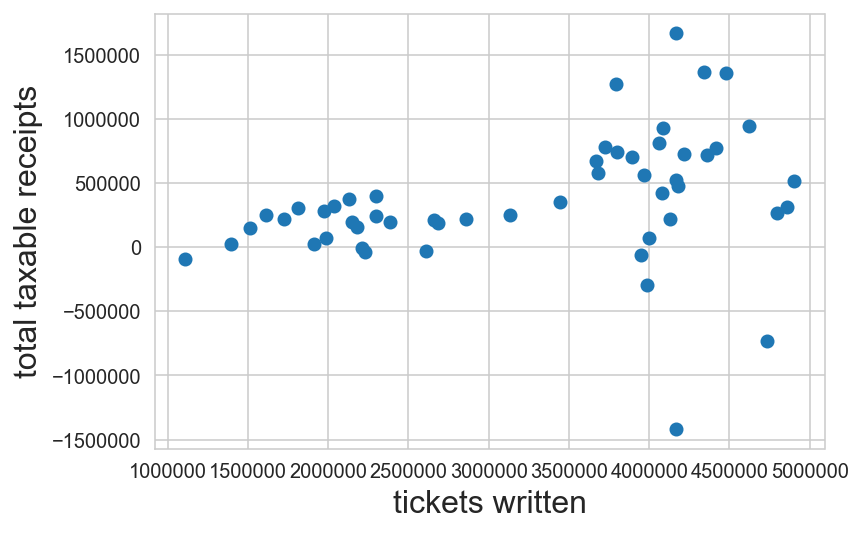

In [19]:
plt.scatter(df["tickets_written"], df["total_taxable_receipts"])
plt.xlabel("tickets written", fontsize = 16)
plt.ylabel("total taxable receipts", fontsize = 16);

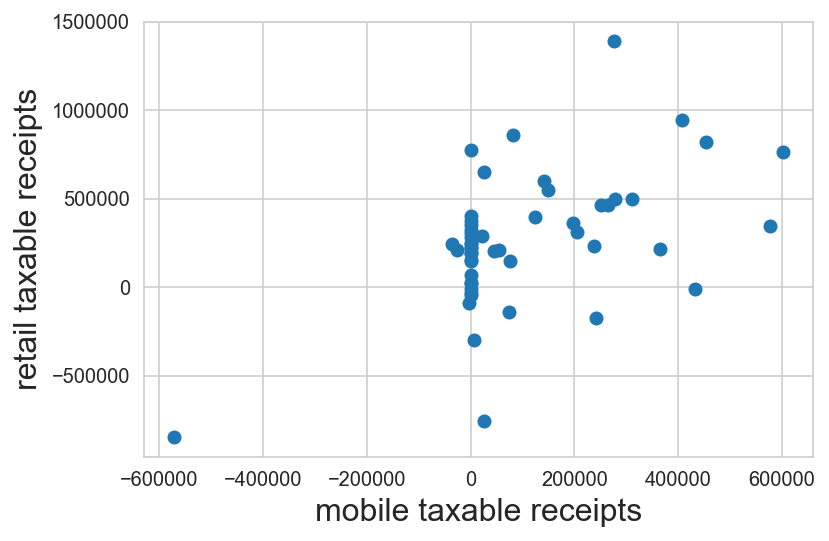

In [20]:
plt.scatter(df['mobile_taxable_receipts'], df['retail_taxable_receipts'])
plt.xlabel("mobile taxable receipts", fontsize = 16)
plt.ylabel("retail taxable receipts", fontsize = 16);

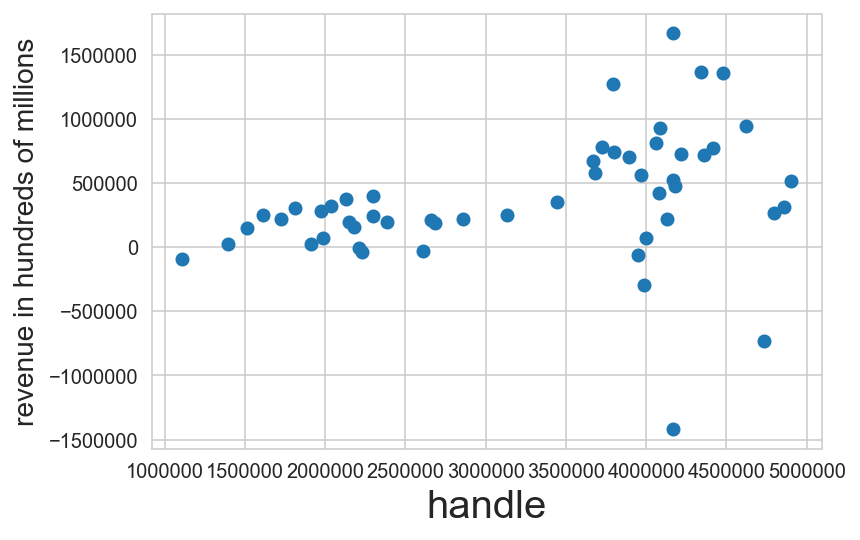

In [21]:
plt.scatter(df['tickets_written'], df['total_taxable_receipts'])
plt.xlabel('handle', fontsize = 20)
plt.ylabel('revenue in hundreds of millions', fontsize = 14);

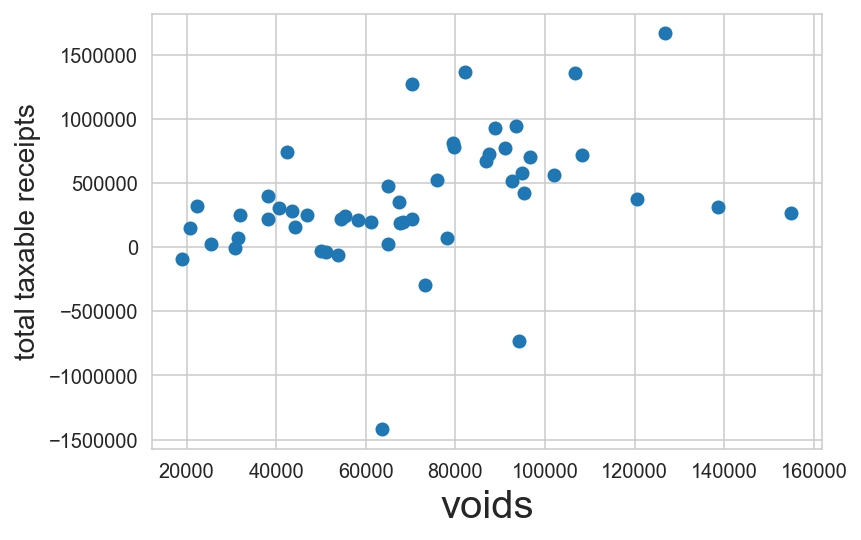

In [22]:
plt.scatter(df['voids'], df['total_taxable_receipts'])
plt.xlabel('voids', fontsize = 20)
plt.ylabel('total taxable receipts', fontsize = 14);

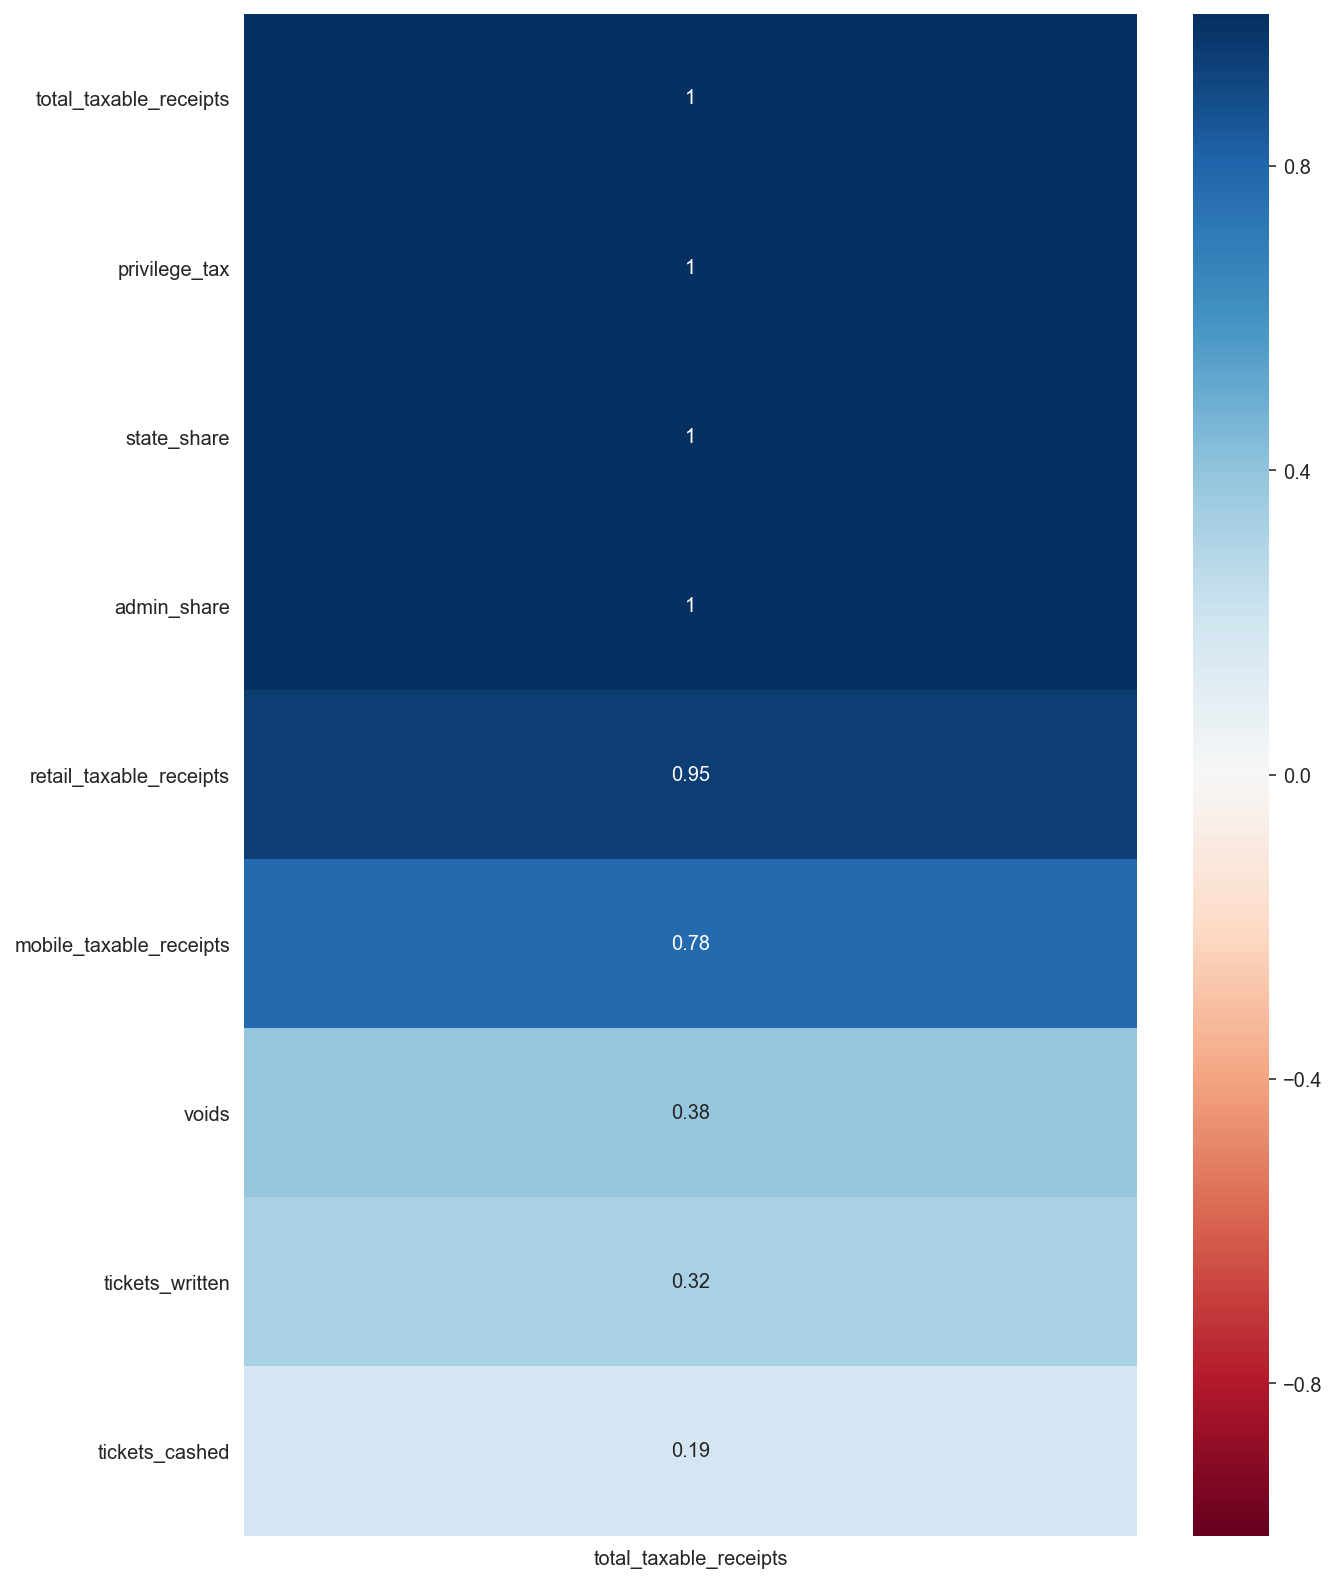

In [23]:
# Heatmap of the corrleations of features and revenue
plt.figure(figsize = (10,14))
sns.heatmap(df.corr()[["total_taxable_receipts"]].sort_values(by = 'total_taxable_receipts', ascending = False),
                            annot = True,
                            cmap="RdBu",
                            vmin = -1,
                            vmax = 1);

### Preprocessing

In [26]:
df.set_index('week_ending', inplace=True)

In [27]:
total_taxable_receipts = pd.DataFrame(df['total_taxable_receipts'].groupby(df.index).sum())

In [28]:
total_taxable_receipts.head()

,total_taxable_receipts
week_ending,
2019-01-05,264445
2019-01-12,310758
2019-01-19,519831
2019-01-26,-292867
2019-02-02,944066


## Time Series EDA (will move up to EDA section)


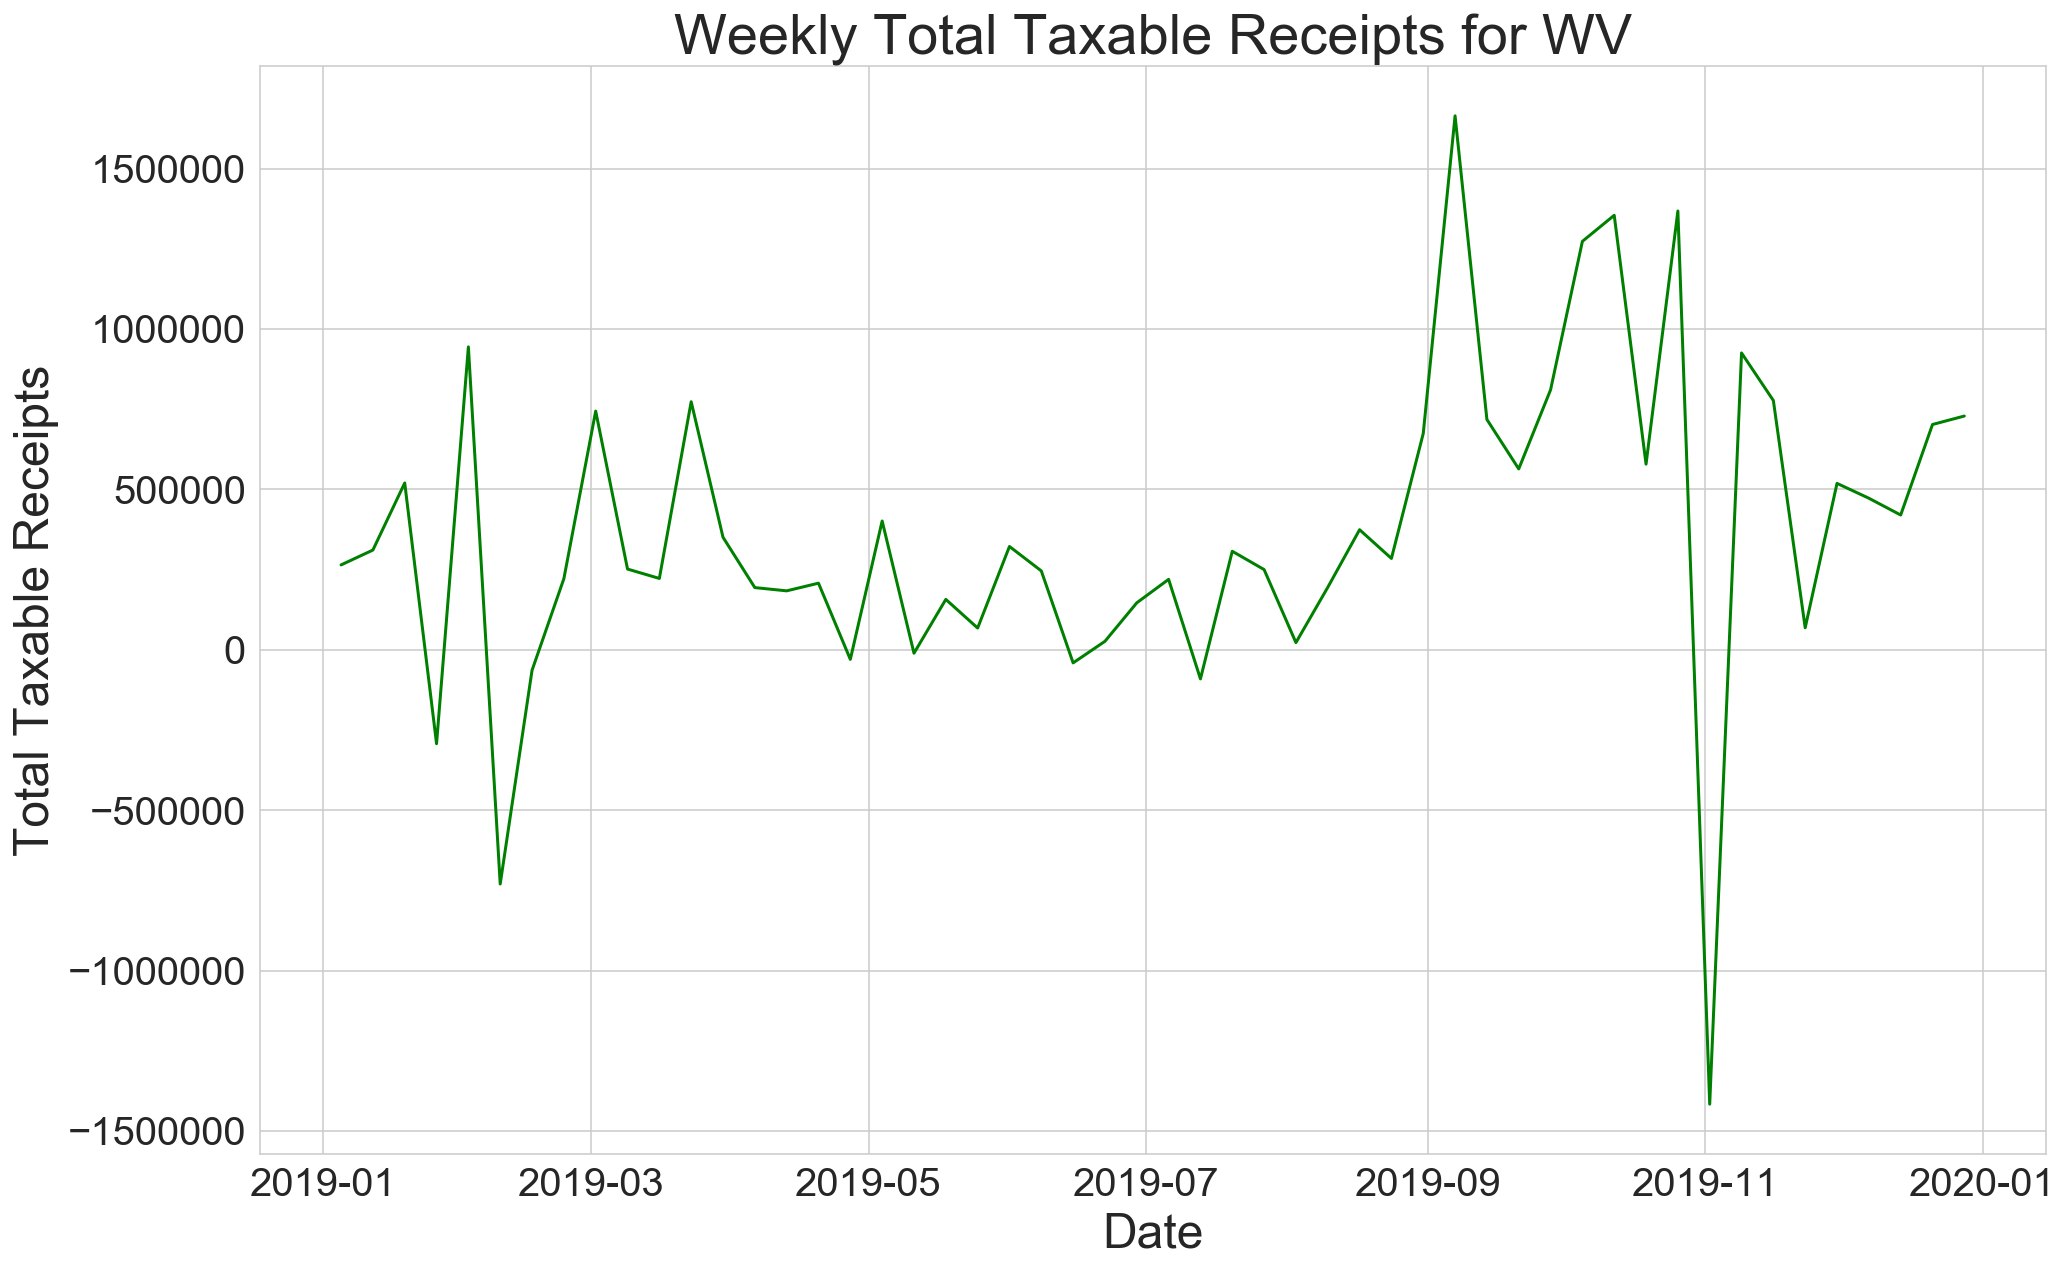

In [29]:
# Set figure size
plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(total_taxable_receipts, c ='green')

# Set labels and title.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Total Taxable Receipts', fontsize=24)
plt.title('Weekly Total Taxable Receipts for WV', fontsize=28);

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time.

In [30]:
# Calculating rolling means for Total Taxable Receipts

rolling_mean_1  = total_taxable_receipts.rolling(window = 1).mean()
rolling_mean_4 = total_taxable_receipts.rolling(window = 4).mean()
rolling_mean_13 = total_taxable_receipts.rolling(window = 13).mean()

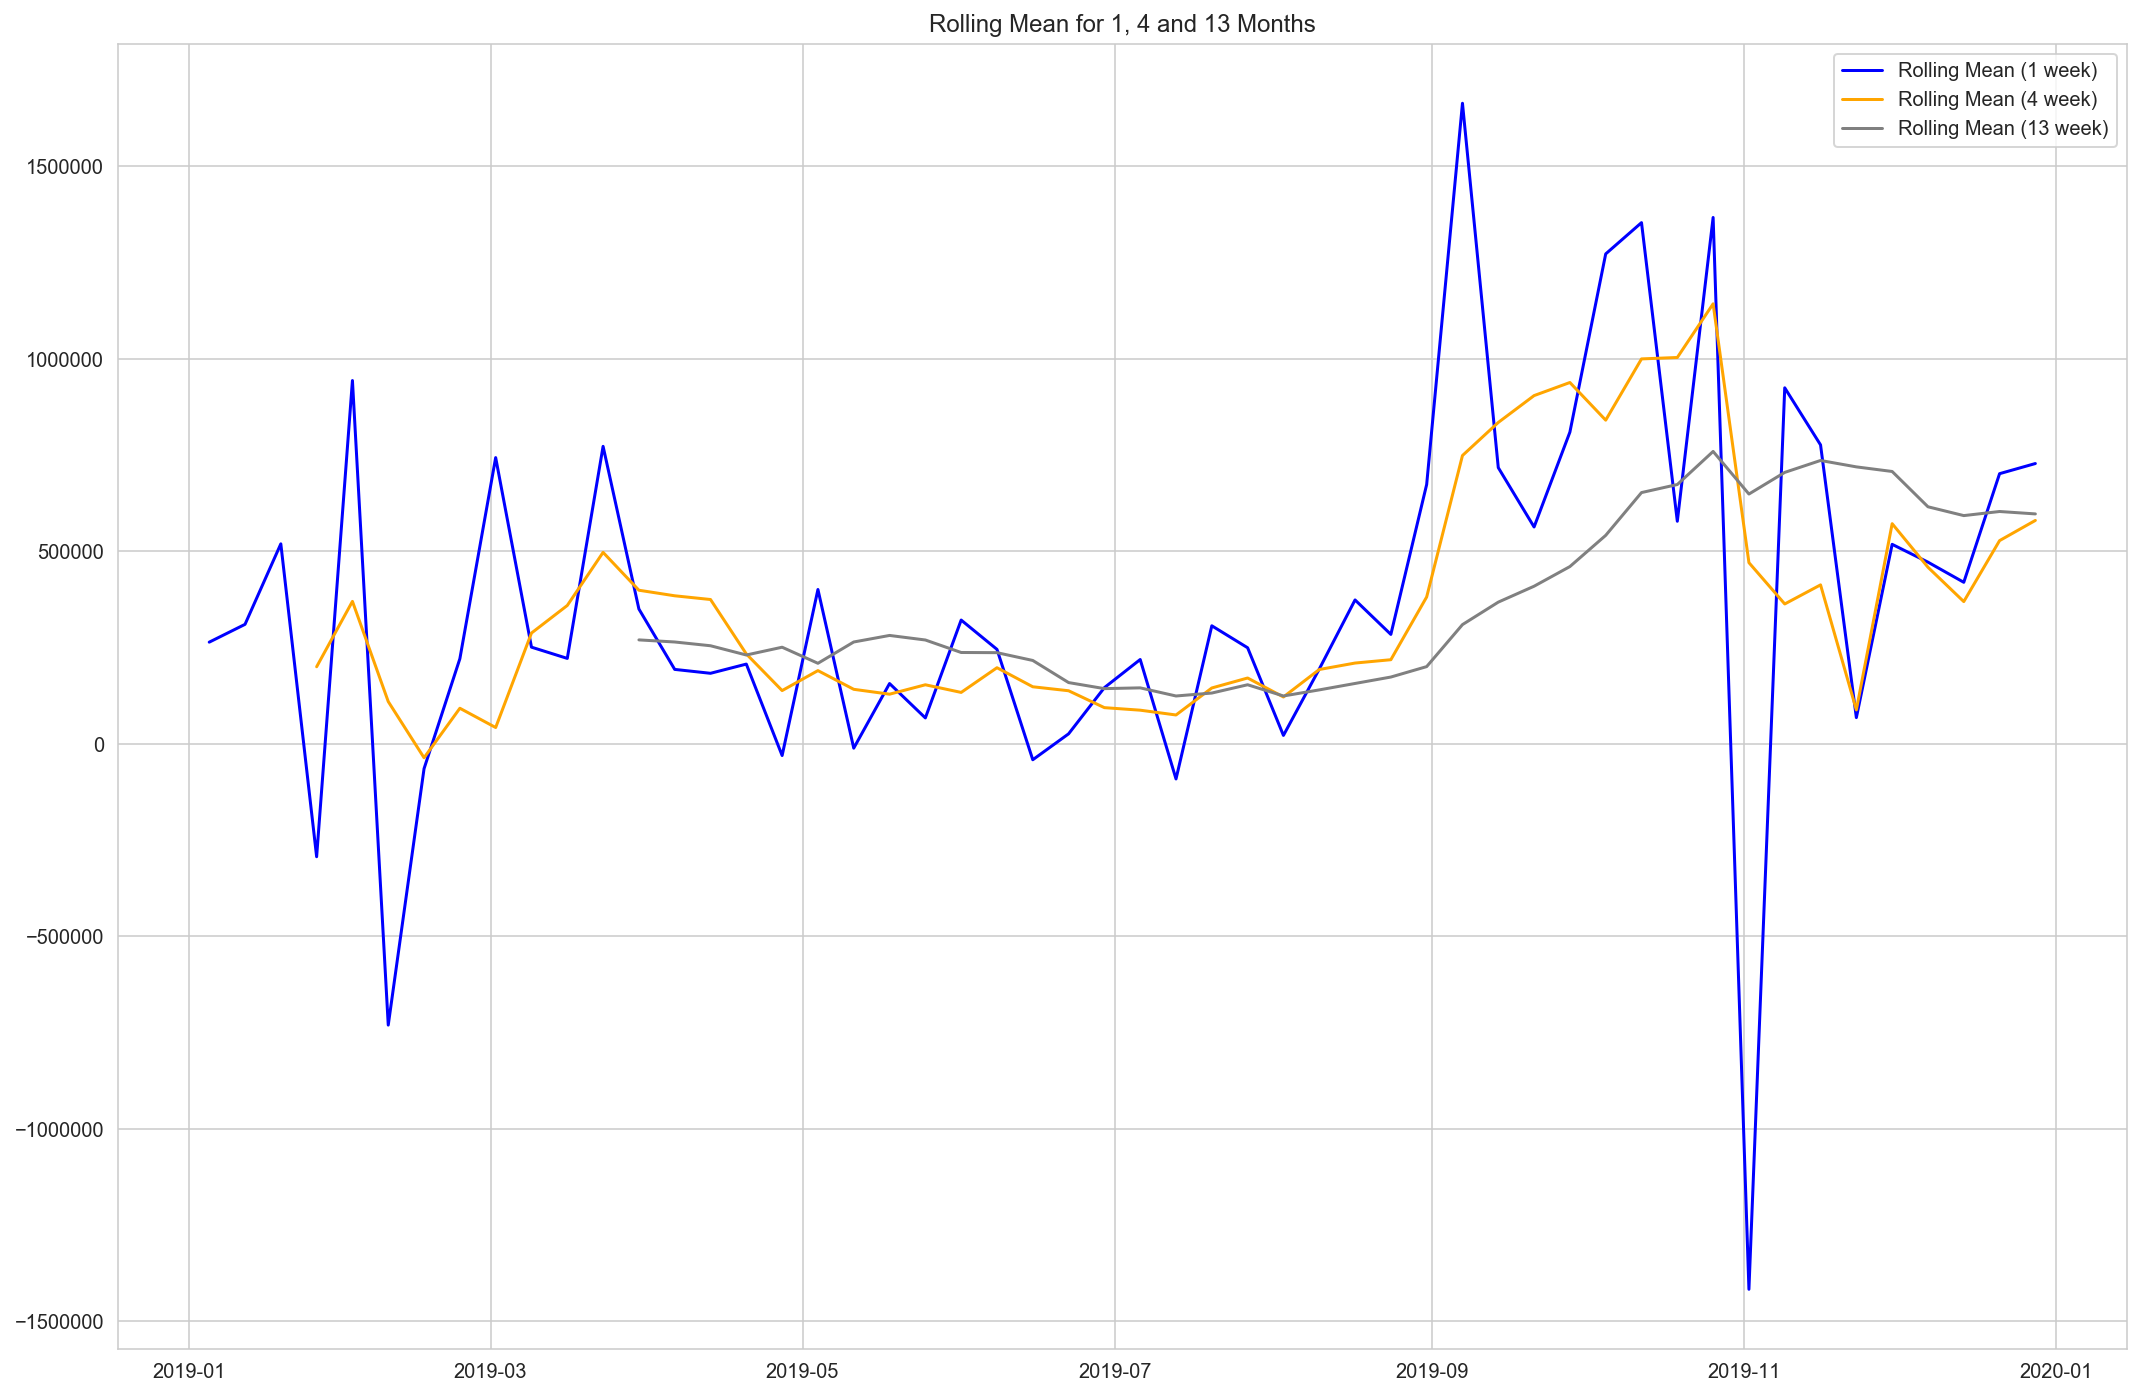

In [31]:
# Plot
plt.figure(figsize=(18,12))
plt.plot(rolling_mean_1, color='blue', label='Rolling Mean (1 week)')
plt.plot(rolling_mean_4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolling_mean_13, color='grey', label='Rolling Mean (13 week)')

plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4 and 13 Months')
plt.show();

In [32]:
# Add interpretation 

In [33]:
# Relationship between Total Taxable Receipts and 1-lag Total Taxable Receipts
total_taxable_receipts["total_taxable_receipts"].autocorr(lag=1)

0.013471643479216042

In [34]:
# Relationship between Total Taxable Receipts and 4-lag Total Taxable Receipts
total_taxable_receipts["total_taxable_receipts"].autocorr(lag=2)

0.22298534166950224

In [35]:
# Relationship between Total Taxable Receipts and 26-lag Total Taxable Receipts
total_taxable_receipts["total_taxable_receipts"].autocorr(lag=26)

-0.1023072690809313

In [36]:
# Add interpretation

#### ACF and PCF

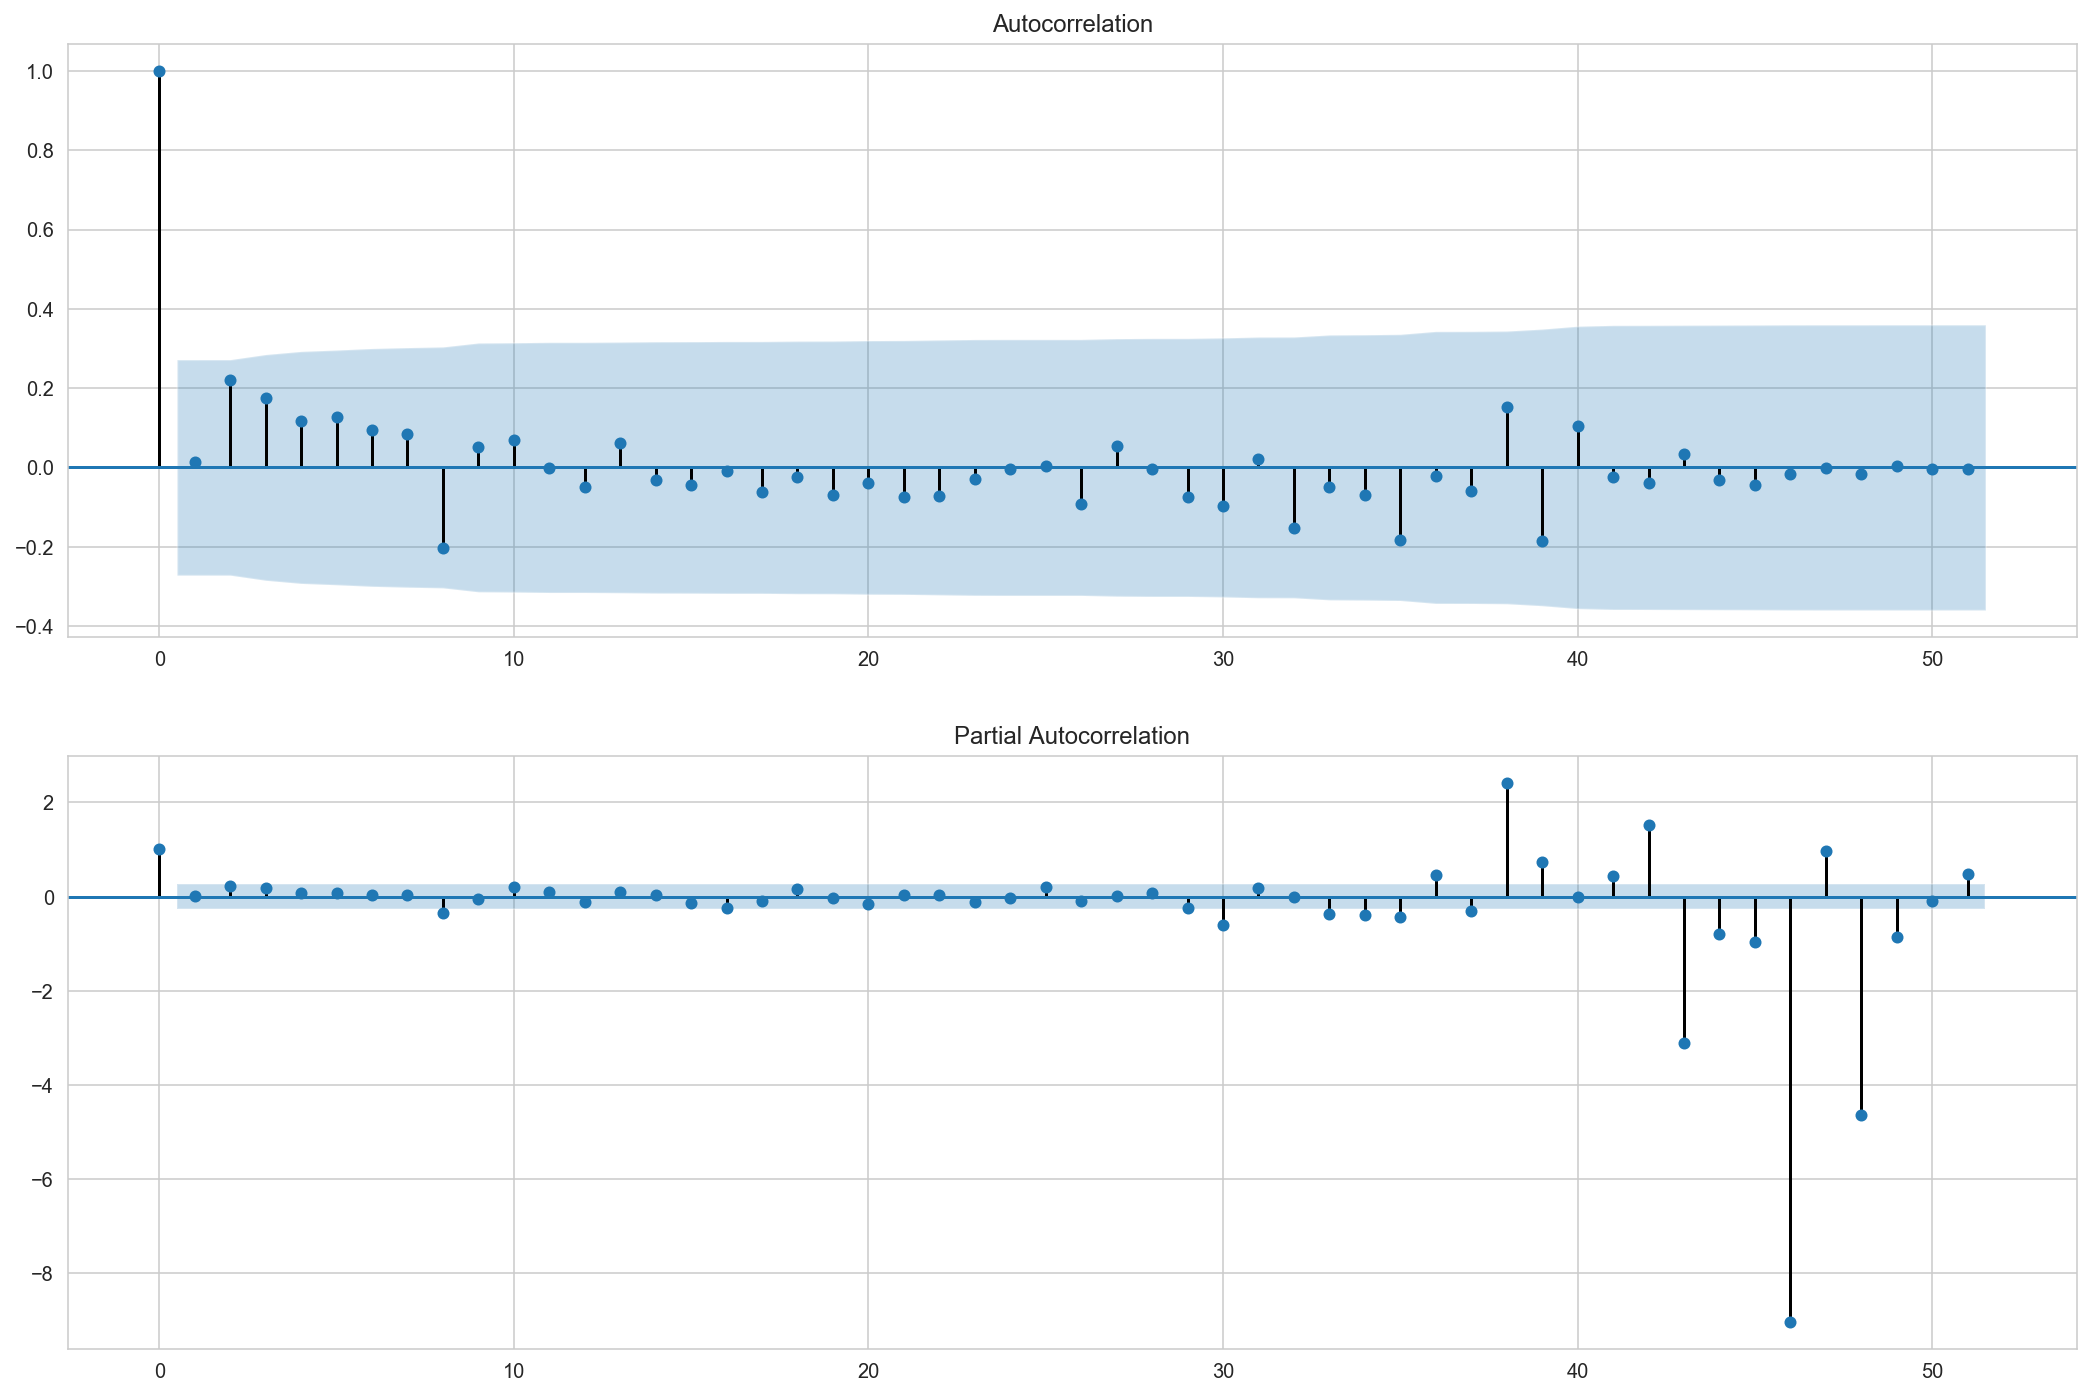

In [40]:
# 51-week ACF AND PCF

fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(total_taxable_receipts, lags=51, ax=ax1)

ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(total_taxable_receipts, lags=51, ax=ax2);

In [45]:
# Add interpretation

## Preprocessing

#### Train-Test-Split

In [41]:
# Using a 75-25 split, our training set will be 39 rows and our test will be 13 rows

train = total_taxable_receipts.iloc[:40,]
test = total_taxable_receipts.iloc[40:,]

In [42]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='pink')
    plt.plot(test, c='blue');

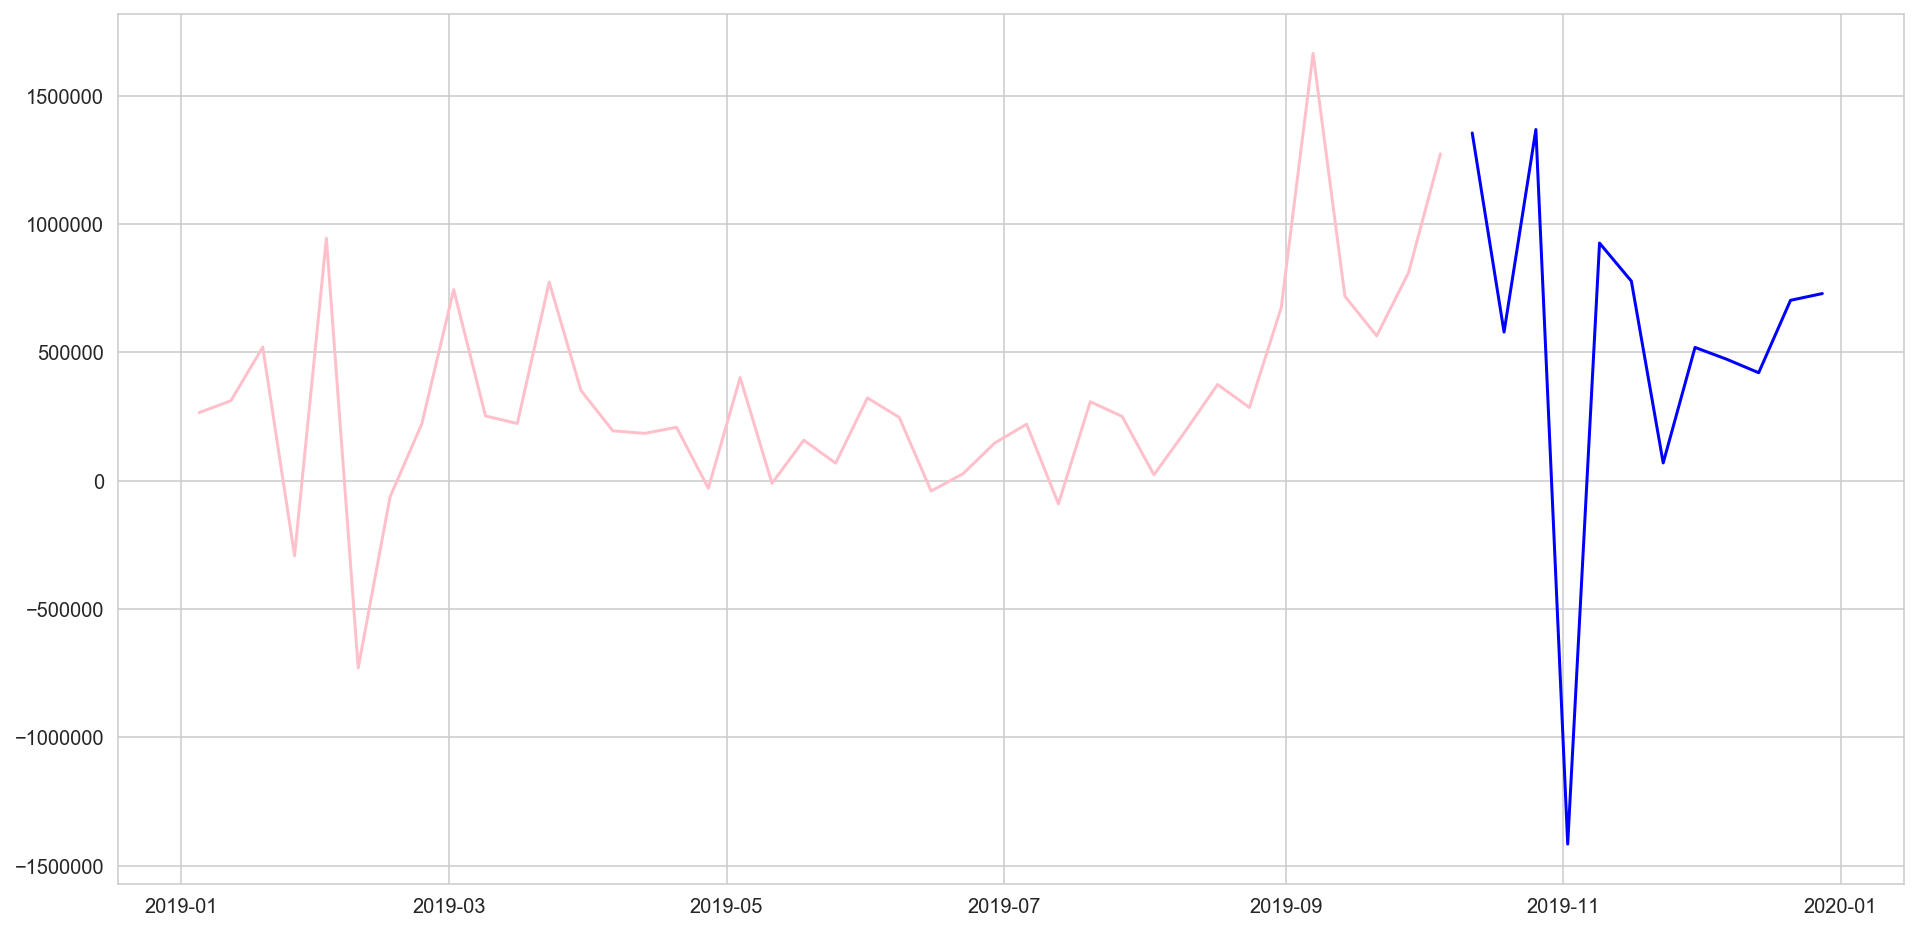

In [43]:
train_test_plot(train, test)

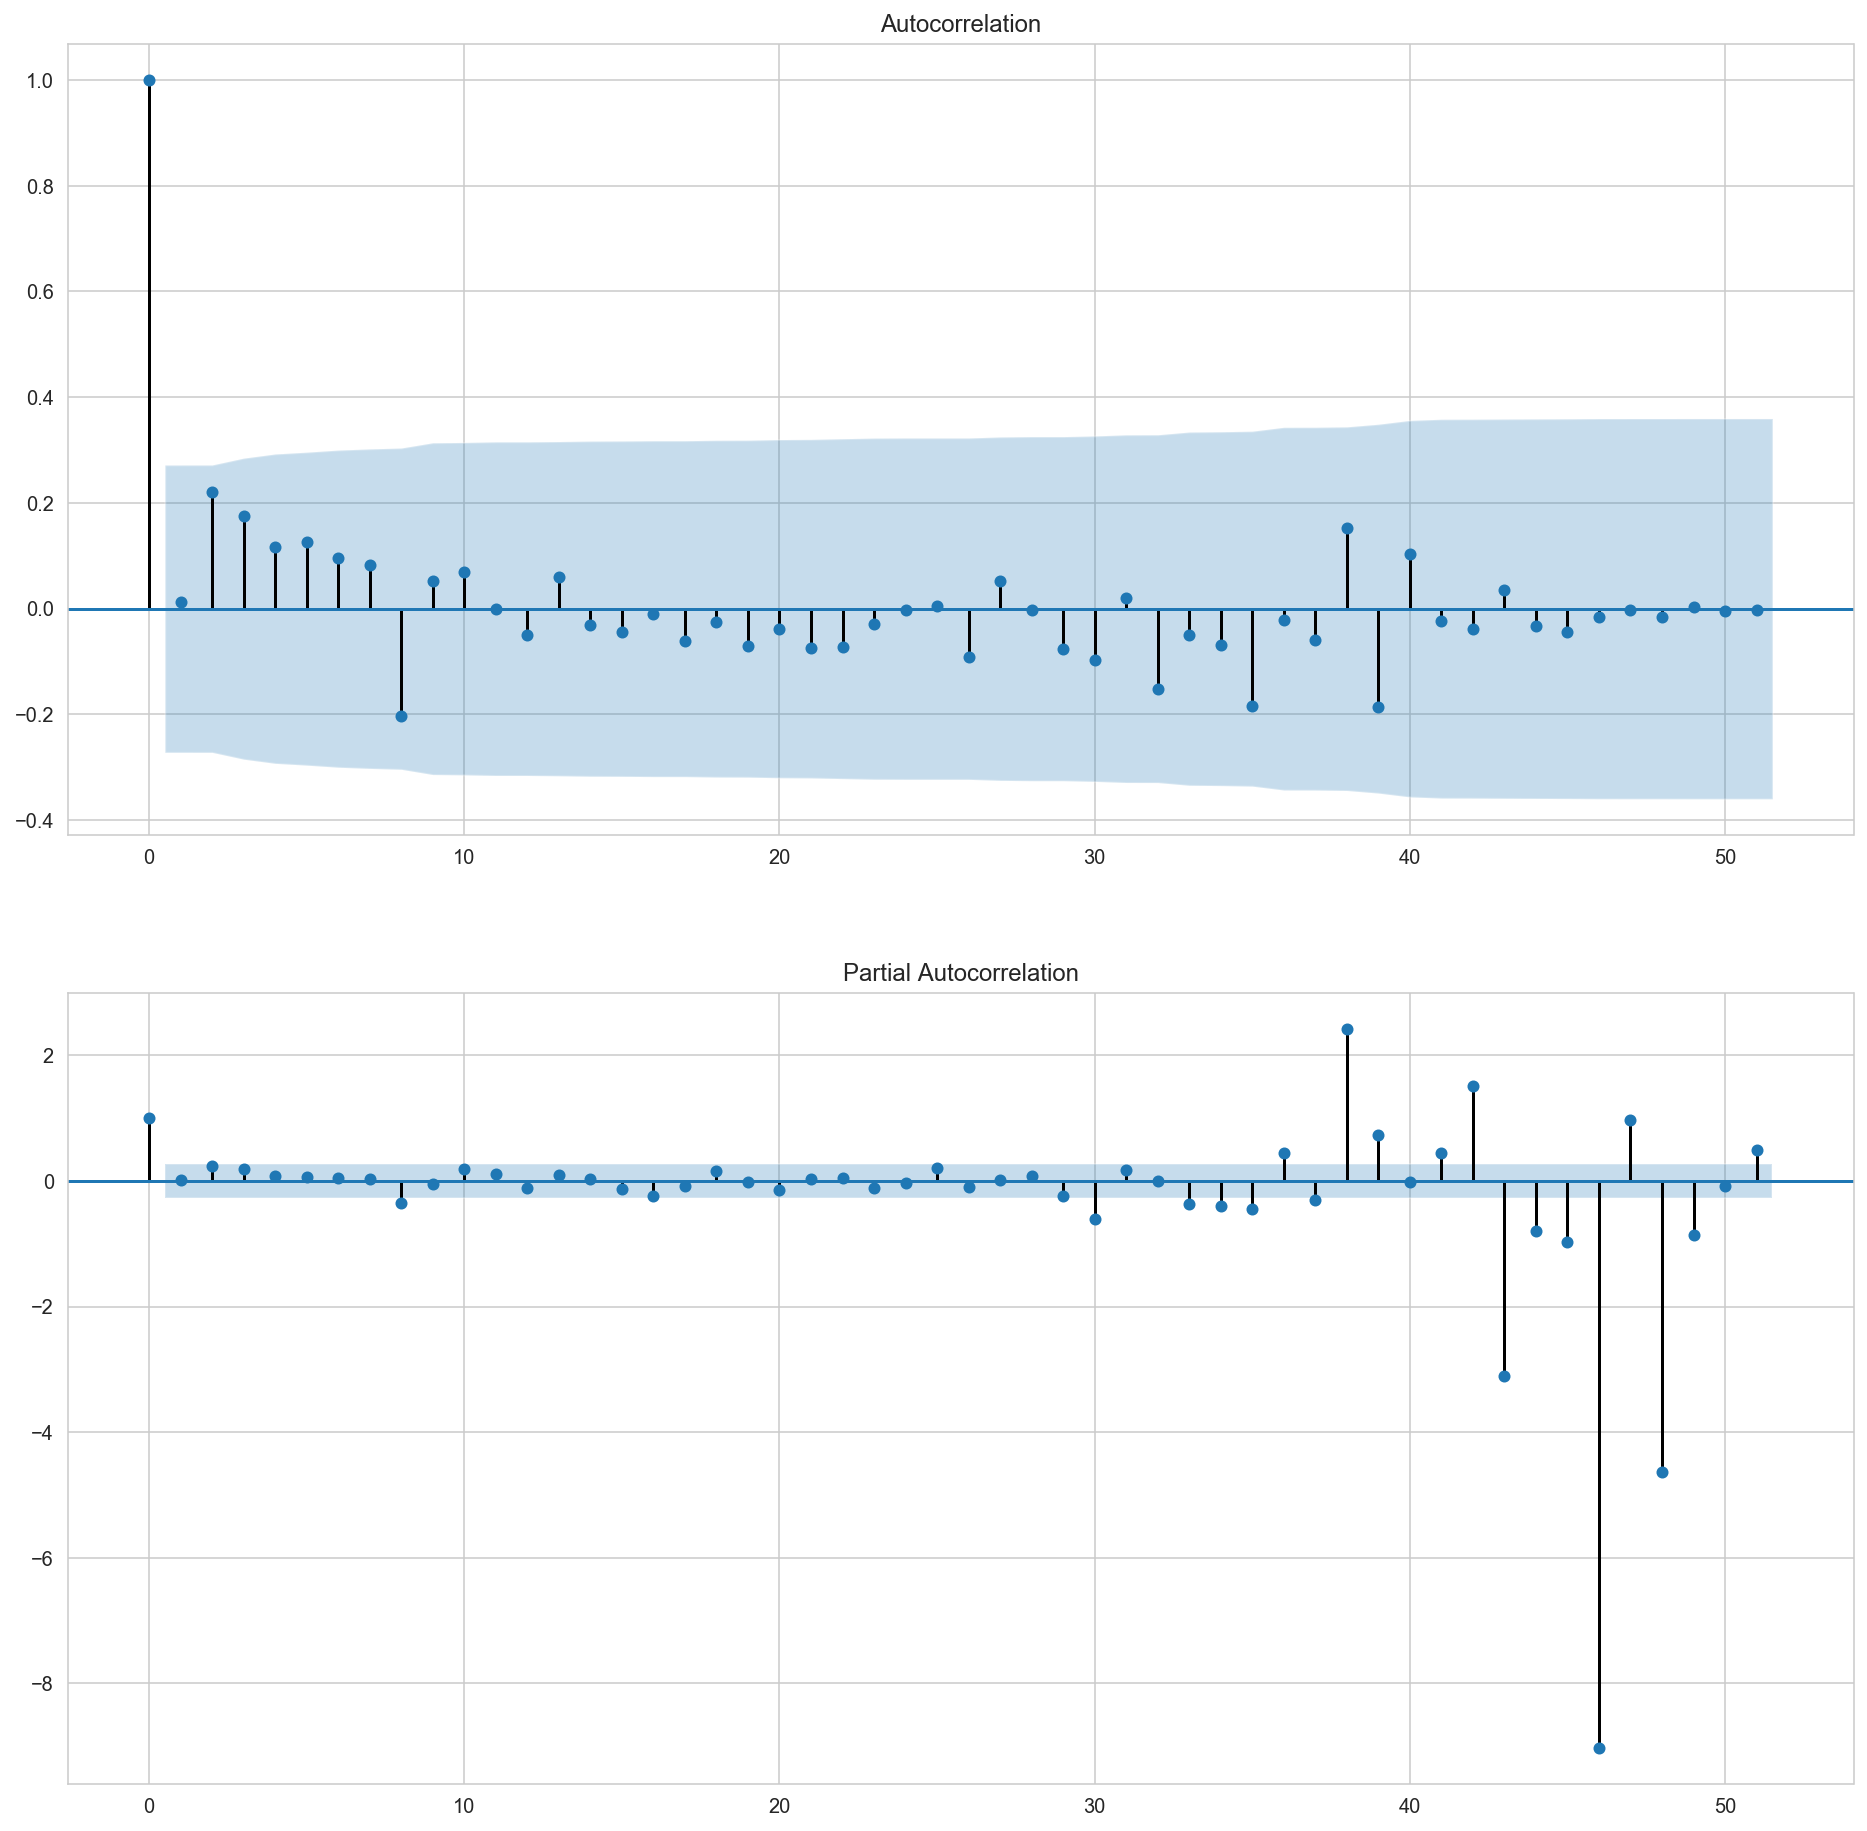

In [44]:

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(total_taxable_receipts, lags=51, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(total_taxable_receipts, lags=51, ax=ax2)
plt.show();

In [47]:
train.head()

,total_taxable_receipts
week_ending,
2019-01-05,264445
2019-01-12,310758
2019-01-19,519831
2019-01-26,-292867
2019-02-02,944066


In [48]:
test.head()

,total_taxable_receipts
week_ending,
2019-10-12,1354195
2019-10-19,578497
2019-10-26,1367608
2019-11-02,-1416411
2019-11-09,925107


##### sarimax params for my reference:
SARIMAX.fit(start_params=None, transformed=True, includes_fixed=False, cov_type=None, cov_kwds=None, method='lbfgs', maxiter=50, full_output=1, disp=5, callback=None, return_params=False, optim_score=None, optim_complex_step=None, optim_hessian=None, flags=None, low_memory=False, **kwargs)

In [57]:
sarima = SARIMAX(endog = train['total_taxable_receipts'],
                 order = (2,0,2),
                 seasonal_order = (0,1,0,51))

In [58]:
model_fit = sarima.fit()

In [59]:
# Use this if we don't include exongenous features

yhat = model_fit.forecast()

In [60]:
yhat

2019-10-12   0.000
Freq: W-SAT, dtype: float64

In [55]:
# Use this if we include exongenous features
# y_hat = model_fit.predict(start = len(train), end = len(train))

In [66]:
total_taxable_receipts

,total_taxable_receipts
week_ending,
2019-01-05,264445
2019-01-12,310758
2019-01-19,519831
2019-01-26,-292867
2019-02-02,944066
2019-02-09,-730156
2019-02-16,-64087
2019-02-23,221454
2019-03-02,743879


In [65]:
# grid search sarima hyperparameters for monthly car sales dataset

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
 
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models
 
if __name__ == '__main__':
    # load dataset
    series = total_taxable_receipts
    data = series.values
    print(data.shape)
    # data split
    n_test = 12
    # model configs
    cfg_list = sarima_configs(seasonal=[0,6,12])
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

SyntaxError: invalid syntax (<ipython-input-65-96e63485b228>, line 116)